In [3]:
import numpy as np

In [70]:
n_0 = 1000
n_1 = 100
p = 0.8
z = np.random.normal(0,1,n_0)
s = np.random.choice([-1,1], p=[1-p,p],size=n_1)

In [106]:
def loss(arg, l_w, l_m, k, t, n):
    w,b = arg
    phi = np.tanh(b + k*t*w*s[:,None] + w*z[None,:])
    phi2 = phi**2
    phi_p = 1-phi2
    phi_pp = -2*phi*phi_p
    phi_s = phi * s[:,None]
    phi_p_s = phi_p * s[:,None]
    phi_pp_s = phi_pp * s[:,None]
    denom = (l_m + n * phi2.mean())**2
    num = n**2 * phi_s.mean()**2 + n*phi.mean()**2
    eq2 = -n*(denom * (phi_pp.mean() * phi.mean() + n * phi_pp_s.mean() * phi_s.mean())-num*((phi_p**2).mean()+(phi*phi_pp).mean()))
    res1 = w*(l_w*denom**2 + eq2) - n*k*t *(denom*(phi_p_s.mean()*phi.mean() + n * phi_p.mean()*phi_s.mean())-num*(phi_s*phi_p).mean())
    res2 = denom*(phi_p.mean()*phi.mean() + n * phi_p_s.mean() * phi_s.mean())-num * (phi*phi_p).mean()
    # return res1**2 + res2**2
    return np.abs(res1) + np.abs(res2)

In [104]:
from scipy.optimize import minimize

In [107]:
res = {}
for t in np.linspace(0,1,20):
    res[t] = minimize(loss,[1,1],args=(0.1,0.1,2,t, n_1), tol=1e-4).x

In [88]:
import pandas as pd

<Axes: >

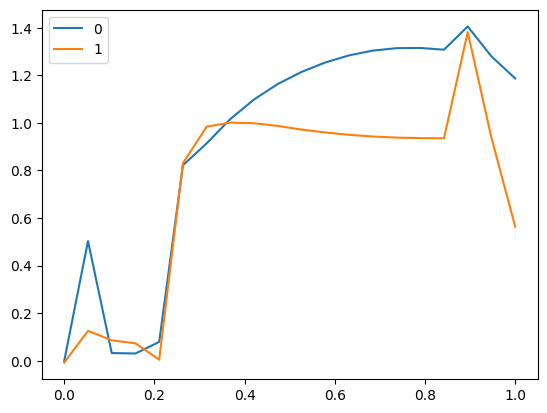

In [89]:
pd.DataFrame(res).T.plot()

In [110]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # Output for w and b

    def forward(self, t):
        t = torch.relu(self.fc1(t))
        t = torch.relu(self.fc2(t))
        out = self.fc3(t)
        return out

# Clean loss function with corrected residuals
def loss_fn(w_b, L_w, L_m, k, t, n, s, z):
    w, b = w_b[:, 0], w_b[:, 1]
    phi = torch.tanh(b[:, None] + k * t * w[:, None] * s[:, None] + w[:, None] * z[None, :])

    phi2 = phi**2
    phi_p = 1-phi2
    phi_pp = -2*phi*phi_p
    phi_s = phi * s[:,None]
    phi_p_s = phi_p * s[:,None]
    phi_pp_s = phi_pp * s[:,None]
    denom = (L_m + n * phi2.mean())**2
    num = n**2 * phi_s.mean()**2 + n*phi.mean()**2
    eq2 = -n*(denom * (phi_pp.mean() * phi.mean() + n * phi_pp_s.mean() * phi_s.mean())-num*((phi_p**2).mean()+(phi*phi_pp).mean()))
    res1 = w*(L_w*denom**2 + eq2) - n*k*t *(denom*(phi_p_s.mean()*phi.mean() + n * phi_p.mean()*phi_s.mean())-num*(phi_s*phi_p).mean())
    res2 = denom*(phi_p.mean()*phi.mean() + n * phi_p_s.mean() * phi_s.mean())-num * (phi*phi_p).mean()
    return (res1**2 + res2**2).mean()


# Hyperparameters
n_0 = 1000
n_1 = 100
p = 0.8
L_w = 1
L_m = 1
k = 1
s = np.random.choice([-1, 1], p=[1-p, p], size=n_1)

# Convert to PyTorch tensors
s = torch.tensor(s, dtype=torch.float32)

# Training setup
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000
t_values = torch.linspace(0, 1, steps=100).reshape(-1, 1)  # Time input

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    w_b = model(t_values)  # Predict w(t) and b(t)

    z = np.random.normal(0, 1, n_0)
    z = torch.tensor(z, dtype=torch.float32)


    loss = loss_fn(w_b, L_w=L_w, L_m=L_m, k=k, t=t_values, n=n_1, s=s, z=z)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Extract predictions for w and b
w_b_pred = model(t_values).detach().numpy()

# Plot the results
df = pd.DataFrame(w_b_pred, columns=["w(t)", "b(t)"])
df["t"] = t_values.detach().numpy()
df.plot(x="t")
plt.show()


RuntimeError: The size of tensor a (100) must match the size of tensor b (1000) at non-singleton dimension 0